In [1]:
import networkx as nx
import random
import numpy as np

random.seed(0)
np.random.seed(0)

## Implement Biased Random Walk

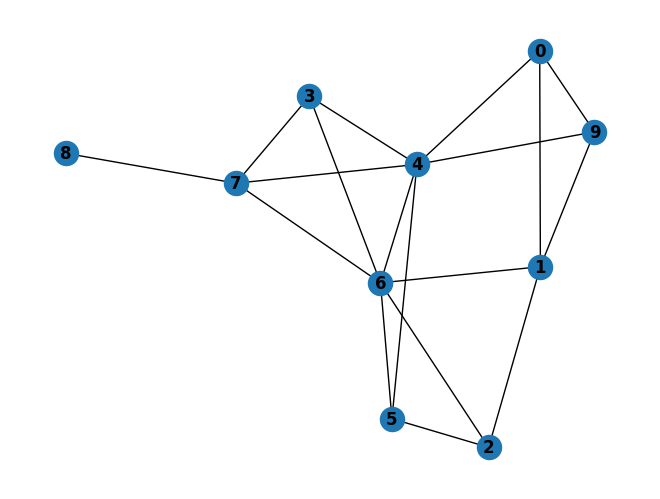

In [2]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)
nx.draw(G, with_labels=True, font_weight='bold')

In [3]:
def next_node_f(previous, current, p, q):
    neighbors = list(G.neighbors(current))
    alphas = []
    for neighbor in neighbors:
        if neighbor == previous:
            alpha = 1/p
        elif G.has_edge(neighbor, previous):
            alpha = 1
        else:
            alpha = 1/q
        alphas.append(alpha)
    # normalize
    probs = [alpha / sum(alphas) for alpha in alphas]

    # random select the next node based on the trasition probabilities calculated
    next_node = np.random.choice(neighbors, 1, p=probs)[0]

    return next_node

In [4]:
def random_walk(start, length, p, q):
    walk = [start]

    for i in range(length):
        current = walk[-1]

        if len(walk) == 1:
            previous = None
        else:
            previous = walk[-2]
        
        next_node = next_node_f(previous, current, p, q)
        walk.append(next_node)
    
    return [str(x) for x in walk]

In [5]:
# p = q = 1 -> random walk
random_walk(0, 10, 1, 1)

['0', '9', '4', '5', '6', '1', '6', '1', '9', '1', '2']

In [6]:
# p high, q low -> DFS
random_walk(0, 10, 1, 0.1)

['0', '1', '6', '4', '7', '3', '6', '3', '6', '5', '6']

In [7]:
# p low, q high -> BFS
random_walk(0, 10, 0.1, 1)

['0', '4', '0', '4', '0', '4', '3', '4', '3', '4', '3']

## Implement Node2Vec

In [8]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [9]:
# load karate club graph
G = nx.karate_club_graph()

In [10]:
# transform the nodes's labels into numerical values (0 and 1)
labels = []
for node in G.nodes:
    if G.nodes[node]['club'] == 'Mr. Hi':
        labels.append(0)
    else:
        labels.append(1)

In [11]:
# generate list of random walks
walks = []
for node in G.nodes:
    for i in range(80):
        walk = random_walk(start=node, length=10, p=1, q=1)
        walks.append(walk)

In [12]:
# create word2vec model and train
node2vec = Word2Vec(walks,
                    hs=1,   # Hierarchical softmax
                    sg=1,   # Skip-gram
                    vector_size=100,
                    window=10,
                    workers=2,
                    min_count=1,
                    seed=0)

node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

(187461, 897600)

In [13]:
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
train_mask_str = [str(x) for x in train_mask]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_mask_str = [str(x) for x in test_mask]
labels = np.array(labels)

In [14]:
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask_str], labels[train_mask])

RandomForestClassifier(random_state=0)

In [15]:
y_pred = clf.predict(node2vec.wv[test_mask_str])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 95.45%


## Movies Recommendation System

In [16]:

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [17]:
import pandas as pd

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [18]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [19]:
# Only consider ratings with the highest score
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [20]:
from collections import defaultdict

pairs = defaultdict(int)

# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [21]:
# Create a networkx graph
G = nx.Graph()

# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


In [22]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


In [23]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Return of the Jedi (1983): 0.61
Raiders of the Lost Ark (1981): 0.55
Godfather, The (1972): 0.49
Indiana Jones and the Last Crusade (1989): 0.46
White Squall (1996): 0.44
